In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression

In [2]:
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv("ames.csv")

In [4]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal,189900


In [10]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X=(X-X.mean(axis=0))/X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca,columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X_pca.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [11]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for col in X.select_dtypes(['object','category']):
        X[col],_=X[col].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(model,X,y,cv=10,
    scoring="neg_mean_squared_log_error"
    )
    score = -1*score.mean()
    score = np.sqrt(score)
    return score

In [12]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]
df[features].corrwith(df.SalePrice)

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64

In [13]:
obj_cols=[col for col in df.columns if df[col].dtype=='object']
num_cols=[col for col in df.columns if df[col].dtype!='object']

In [14]:
X=df.copy()
Y=X.pop('SalePrice')
X=X.loc[:,features]

In [17]:
#Loading column consists of w_{ij} s.t. PCi=w_{i1}F1 + w_{i2}F2+...
pca,X_pca,loadings=apply_pca(X)
print(X_pca)

           PC1       PC2       PC3       PC4
0    -0.165346  1.164936  0.233330  0.283527
1    -0.639050  0.649561 -0.622155  1.740770
2    -0.794227  1.175790 -0.580254 -0.551055
3     1.636658  1.907874 -0.675063 -1.052854
4     0.293648 -0.610856  0.342374 -0.047752
...        ...       ...       ...       ...
2925 -0.276496 -0.239255 -0.676658  0.820547
2926 -0.822084 -0.414039 -0.593885  0.620322
2927 -1.730457 -0.951137 -0.501221 -1.417521
2928 -0.049130  0.584898 -0.641779 -0.374198
2929  1.090406 -0.106617  0.763916  0.328966

[2930 rows x 4 columns]


In [16]:
score_dataset(X,Y)

0.1964096762683649

In [18]:
#Score gets better after including the most variance component.
X['PCA1']=X_pca['PC1']
score_dataset(X,Y)

0.1927534391118239

In [24]:
X['PCA2']=X_pca['PC2']
score_dataset(X,Y)

0.19173122194824946

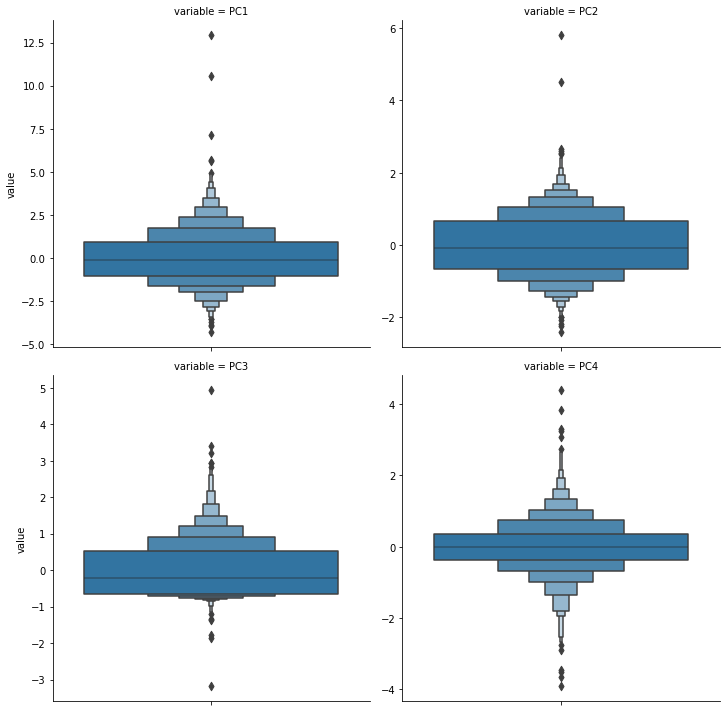

In [19]:
#Outlier visualization
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [22]:
#Outliers
idx=X['PCA1'].sort_values(ascending=False).index
df.loc[idx,['SalePrice']+features]

,SalePrice,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,1418.0,2008,6110.0,5642.0
2180,183850,1154.0,2009,5095.0,5095.0
2181,184750,884.0,2008,3138.0,4676.0
1760,745000,813.0,1996,2396.0,4476.0
1767,755000,832.0,1995,2444.0,4316.0
...,...,...,...,...,...
662,59000,0.0,1950,416.0,599.0
2679,80500,0.0,1950,0.0,912.0
2879,51689,0.0,1950,0.0,729.0
780,63900,0.0,1950,0.0,660.0


In [26]:
#Feature creation
X_1 = pd.DataFrame()  # dataframe to hold new features
X_1["LivLotRatio"] = df.GrLivArea/df.LotArea
X_1["Spaciousness"] = (df.FirstFlrSF+df.SecondFlrSF)/df.TotRmsAbvGrd
X_1["TotalOutsideSF"] = df.WoodDeckSF+df.OpenPorchSF+df.EnclosedPorch+df.Threeseasonporch+df.ScreenPorch

In [31]:
# One-hot encode BldgType. Use `prefix="Bldg"` in `get_dummies`
X_2 = pd.get_dummies(df.BldgType,prefix='Bldg') 
# Multiply
X_2.mul(df.GrLivArea,axis=0)

,Bldg_Duplex,Bldg_OneFam,Bldg_Twnhs,Bldg_TwnhsE,Bldg_TwoFmCon
0,0.0,1656.0,0.0,0.0,0.0
1,0.0,896.0,0.0,0.0,0.0
2,0.0,1329.0,0.0,0.0,0.0
3,0.0,2110.0,0.0,0.0,0.0
4,0.0,1629.0,0.0,0.0,0.0
...,...,...,...,...,...
2925,0.0,1003.0,0.0,0.0,0.0
2926,0.0,902.0,0.0,0.0,0.0
2927,0.0,970.0,0.0,0.0,0.0
2928,0.0,1389.0,0.0,0.0,0.0


In [43]:
#Create a feature PorchTypes that counts how many of the following 
#are greater than 0.0:
X_3 = pd.DataFrame()
cols=['WoodDeckSF','OpenPorchSF','EnclosedPorch','Threeseasonporch','ScreenPorch']
# greater than 0
X_3["PorchTypes"] = df[cols].gt(0).sum(axis=1)

In [54]:
#Create a feature containing only these first words by splitting 
#MSSubClass at the first underscore _. 
X_4=pd.DataFrame()
X_4['MSClass']=df.MSSubClass.str.split('_',n=1,expand=True)[0]

In [59]:
df.MSSubClass.str.split('_',n=1)

0       [One, Story_1946_and_Newer_All_Styles]
1       [One, Story_1946_and_Newer_All_Styles]
2       [One, Story_1946_and_Newer_All_Styles]
3       [One, Story_1946_and_Newer_All_Styles]
4                  [Two, Story_1946_and_Newer]
                         ...                  
2925                    [Split, or_Multilevel]
2926    [One, Story_1946_and_Newer_All_Styles]
2927                            [Split, Foyer]
2928    [One, Story_1946_and_Newer_All_Styles]
2929               [Two, Story_1946_and_Newer]
Name: MSSubClass, Length: 2930, dtype: object

In [68]:
#Create a feature MedNhbdArea that describes the median of 
# GrLivArea grouped on Neighborhood.
X_5=pd.DataFrame()
X_5['MedNhbdArea']=df.groupby('Neighborhood').GrLivArea.transform('median')

In [70]:
X_5.head(3)

,MedNhbdArea
0,1200.0
1,1200.0
2,1200.0


In [72]:
#Far better
X_new = X.join([X_1, X_2, X_3, X_4, X_5])
score_dataset(X_new, Y)

0.17034118810583251